In [1]:
import pandas as pd

df_hn = pd.read_csv("AQI_HaNoi_Updated.csv", parse_dates=["date"],index_col=["date"])
df_dn = pd.read_csv("AQI_DaNang_Updated.csv", parse_dates=["date"],index_col=["date"])
df_vt = pd.read_csv("AQI_VietTri_Updated.csv", parse_dates=["date"],index_col=["date"])

cols = ['AQI']
df_hn = df_hn[cols]
df_dn = df_dn[cols]
df_vt = df_vt[cols]

df_hn.head()

,AQI
date,
2019-01-01,72.0
2019-01-02,68.0
2019-01-03,94.0
2019-01-04,105.0
2019-01-05,80.0


In [2]:
import tensorflow as tf

# Tạo lớp NBeatsBlock
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # hàm tạo lấy tất cả các siêu tham số cho lớp
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # đối số **kwargs đảm nhiệm tất cả các đối số cho lớp cha (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Khối chứa 4 lớp 'full_connected', mỗi lớp có kích hoạt ReLU
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Đầu ra của khối là lớp theta có kích hoạt tuyến tính
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # phương thức 'call' sẽ chạy khi lớp được gọi
    x = inputs
    for layer in self.hidden: # chuyển đầu vào qua từng lớp ẩn
      x = layer(x)
    theta = self.theta_layer(x)
    # Xuất 'backcast' và 'forecast' từ theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [3]:
HORIZON = 1 # khoảng thời gian mà mô hình sẽ dự đoán trước
WINDOW_SIZE = 7 # số lượng bước thời gian mà mô hình sẽ nhìn lại để đưa ra dự đoán

In [4]:
# Các giá trị từ bài báo N-BEATS Hình 1 và Bảng 18/Phụ lục D
N_EPOCHS = 5000 # được gọi là "Iterations" trong Bảng 18
N_NEURONS = 512 # được gọi là "Width" trong Bảng 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # được gọi là "Lookback" trong Bảng 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [5]:
from tensorflow.keras import layers
# tạo tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

subtracted = layers.subtract([tensor_1, tensor_2])

added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


In [6]:
tf.random.set_seed(42)

# 1. Thiết lập lớp khối N-BEATS
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

In [7]:
# 2. Tạo đầu vào cho ngăn xếp
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

In [8]:
# 3. Tạo đầu vào dự báo và dự báo ngược ban đầu (dự đoán ngược được gọi là phần dư trong bài báo)
backcast, forecast = nbeats_block_layer(stack_input)

residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

In [9]:
# 4. Tạo ngăn xếp các khối
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Sử dụng NBeatsBlock để tính toán dự báo backcast cũng như khối
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # chuyển nó thành phần dư (backcast)

  # 6. Tạo xếp chồng dư kép
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

In [10]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # trả về mảng dự đoán 1D

In [11]:
def evaluate_preds(y_true, y_pred):
  # Đảm bảo float32 (để tính toán số liệu)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Tính toán các chỉ số khác nhau
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  # Tính đến các số liệu có kích thước khác nhau (đối với tầm nhìn dài hơn, hãy giảm xuống một số)
  if mae.ndim > 0: # nếu mae chưa phải là đại lượng vô hướng, hãy giảm nó thành một bằng cách tổng hợp các tensor thành có nghĩa
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)

  return {"mae": mae.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          }

# Hà Nội

In [12]:
# Thêm các cột window
df_nbeats = df_hn.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"AQI+{i+1}"] = df_nbeats["AQI"].shift(periods=i+1)
df_nbeats.dropna().head()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
date,,,,,,,,
2019-01-08,68.000000,76.000000,130.000000,80.0,105.0,94.0,68.0,72.0
2019-01-09,92.000000,68.000000,76.000000,130.0,80.0,105.0,94.0,68.0
2019-01-10,152.857143,92.000000,68.000000,76.0,130.0,80.0,105.0,94.0
2019-01-11,62.000000,152.857143,92.000000,68.0,76.0,130.0,80.0,105.0
2019-01-12,143.333333,62.000000,152.857143,92.0,68.0,76.0,130.0,80.0


## Hà Nội, Train:Test - 7:3

In [13]:
# Tạo đặc điểm và nhãn
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

# Tạo bộ huấn luyện và bộ kiểm tra
split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1380, 1380, 592, 592)

In [14]:
# 1. Làm mảng huấn luyện và kiểm tra thành Bộ dữ liệu tensor
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Kết hợp các đặc điểm và nhãn
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3.  Chia dữ liệu huấn luyện thành các nhóm nhỏ (batches) and Tự động điều chỉnh số lượng batches để có hiệu suất tối ưu
BATCH_SIZE = 1024 # lấy từ Phụ lục D trong bài báo N-BEATS
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:
# 7. Đặt mô hình ngăn xếp lại với nhau
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_HaNoi_73_N-BEATS")

In [16]:
# 8. Biên dịch với mất MAE và trình tối ưu hóa Adam
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [17]:
# 9. Điều chỉnh mô hình bằng các lệnh gọi lại EarlyStopping và ReduceLROnPlateau
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 117: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 217: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [18]:
# Đánh giá mô hình N-BEATS trên tập dữ liệu thử nghiệm
model.evaluate(test_dataset)

1/1 [==============================] - 0s 22ms/step - loss: 24.3788 - mae: 24.3788 - mse: 976.8724


[24.37882423400879, 24.37882423400879, 976.8724365234375]

In [19]:
# Đưa ra dự đoán với mô hình N-BEATS
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([105.41723 , 113.564964,  57.518047,  65.38962 ,  95.17815 ,
       109.295135, 146.68457 , 112.70504 , 145.52463 ,  96.34173 ],
      dtype=float32)>

In [20]:
# Đánh giá dự đoán mô hình N-Beats
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 24.378824, 'rmse': 31.25496, 'mape': 20.7709}

In [21]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

In [22]:
import matplotlib.pyplot as plt

def predict_future_aqi(model, initial_input, n_days):
    predictions = []
    current_input = initial_input

    for _ in range(n_days):
        # Đưa ra dự đoán cho ngày hôm sau
        next_prediction = model.predict(tf.expand_dims(current_input, axis=0))
        next_prediction = tf.squeeze(next_prediction).numpy()

        predictions.append(next_prediction)

        # Cập nhật cửa sổ đầu vào cho lần lặp tiếp theo
        current_input = np.append(current_input[1:], next_prediction)

    return np.array(predictions)

1/1 [==============================] - 0s 23ms/step


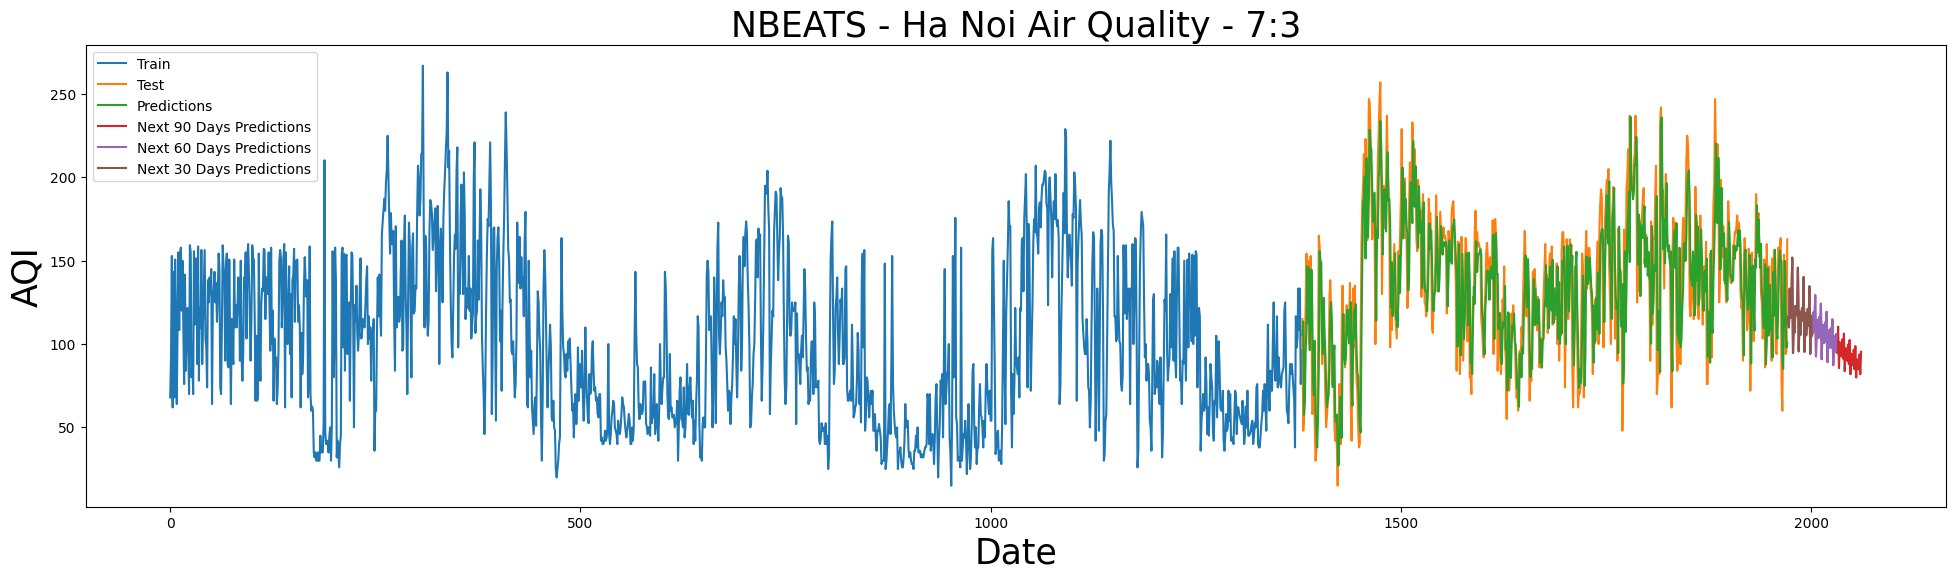

In [23]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Ha Noi Air Quality - 7:3', fontsize = 25)
plt.legend()
plt.show()

## Hà Nội, Train:Test - 8:2

In [24]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1577, 1577, 395, 395)

In [25]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [26]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_HaNoi_82_N-BEATS")

In [27]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [28]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 116: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 216: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [29]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 22ms/step - loss: 24.8671 - mae: 24.8671 - mse: 1041.6555


[24.86710548400879, 24.86710548400879, 1041.655517578125]

In [30]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([102.73991 , 119.14056 , 142.54562 , 149.246   , 149.85352 ,
       103.602516, 157.06317 , 137.11835 ,  96.67944 ,  98.74176 ],
      dtype=float32)>

In [31]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 24.867105, 'rmse': 32.27469, 'mape': 20.479322}

In [32]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 28ms/step


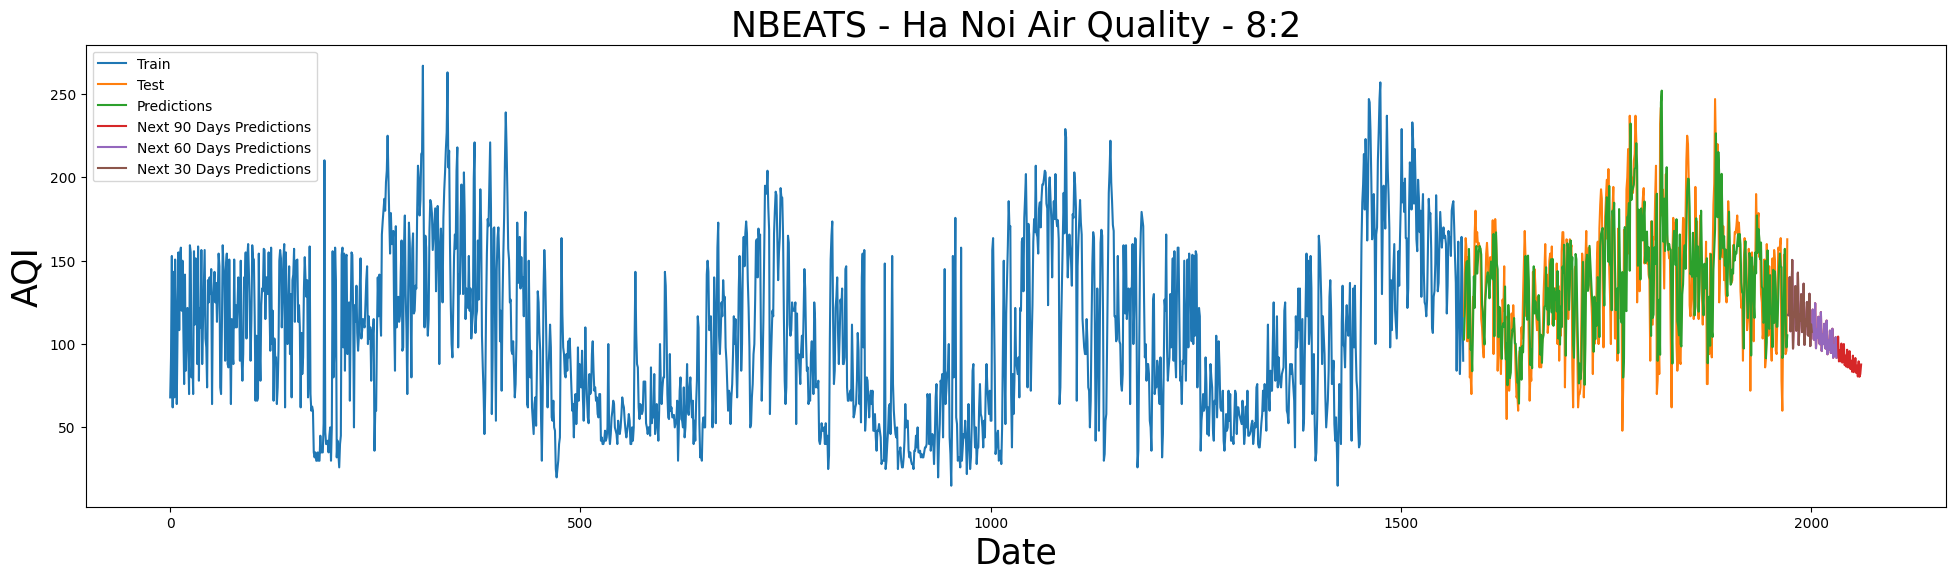

In [33]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Ha Noi Air Quality - 8:2', fontsize = 25)
plt.legend()
plt.show()

## Hà Nội, Train:Test - 9:1

In [34]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1774, 1774, 198, 198)

In [35]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [36]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_HaNoi_91_N-BEATS")

In [37]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [38]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 112: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 212: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [39]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 19ms/step - loss: 26.2040 - mae: 26.2040 - mse: 1212.0031


[26.203975677490234, 26.203975677490234, 1212.0030517578125]

In [40]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([102.263504, 123.18551 , 163.63483 , 170.23993 , 192.26547 ,
       148.55939 , 213.96925 , 193.75354 , 188.74243 , 189.33163 ],
      dtype=float32)>

In [41]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 26.203976, 'rmse': 34.813835, 'mape': 19.591984}

In [42]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 24ms/step


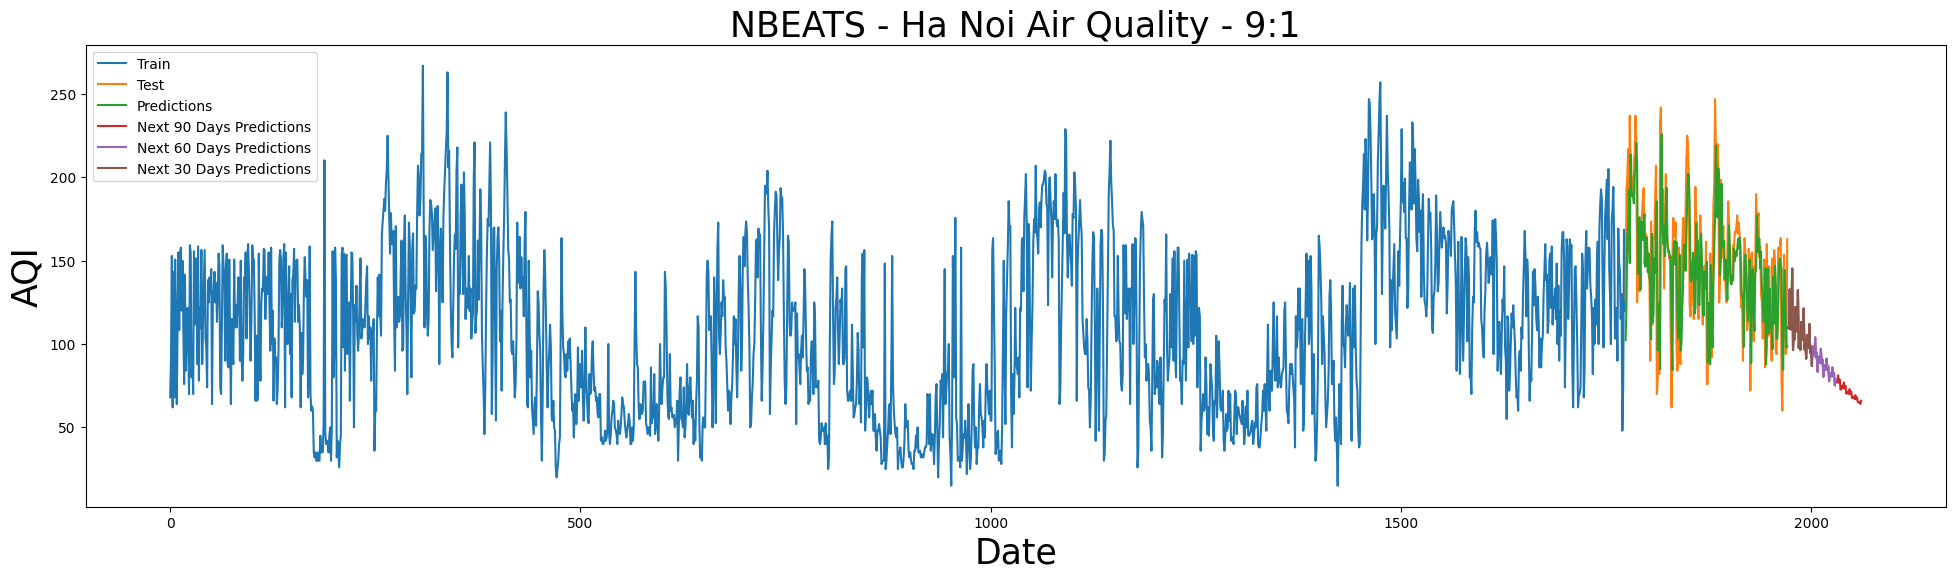

In [43]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Ha Noi Air Quality - 9:1', fontsize = 25)
plt.legend()
plt.show()

# Đà Nẵng

In [44]:
# Thêm các cột window
df_nbeats = df_dn.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"AQI+{i+1}"] = df_nbeats["AQI"].shift(periods=i+1)
df_nbeats.dropna().head()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
date,,,,,,,,
2019-01-08,179.285714,168.571429,153.571429,90.000000,80.000000,64.000000,52.000000,52.0
2019-01-09,152.142857,179.285714,168.571429,153.571429,90.000000,80.000000,64.000000,52.0
2019-01-10,154.285714,152.142857,179.285714,168.571429,153.571429,90.000000,80.000000,64.0
2019-01-11,164.285714,154.285714,152.142857,179.285714,168.571429,153.571429,90.000000,80.0
2019-01-12,148.333333,164.285714,154.285714,152.142857,179.285714,168.571429,153.571429,90.0


## Đà Nẵng, Train:Test - 7:3

In [45]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1380, 1380, 592, 592)

In [46]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [47]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_DaNang_73_N-BEATS")

In [48]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [49]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 109: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 209: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [50]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 24.0653 - mae: 24.0653 - mse: 1267.6287


[24.06528091430664, 24.06528091430664, 1267.628662109375]

In [51]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([72.48411 , 81.962   , 77.381516, 64.247894, 99.53495 , 89.5582  ,
       48.781616, 64.81873 , 92.198006, 79.39709 ], dtype=float32)>

In [52]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 24.06528, 'rmse': 35.60377, 'mape': 42.578712}

In [53]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 23ms/step


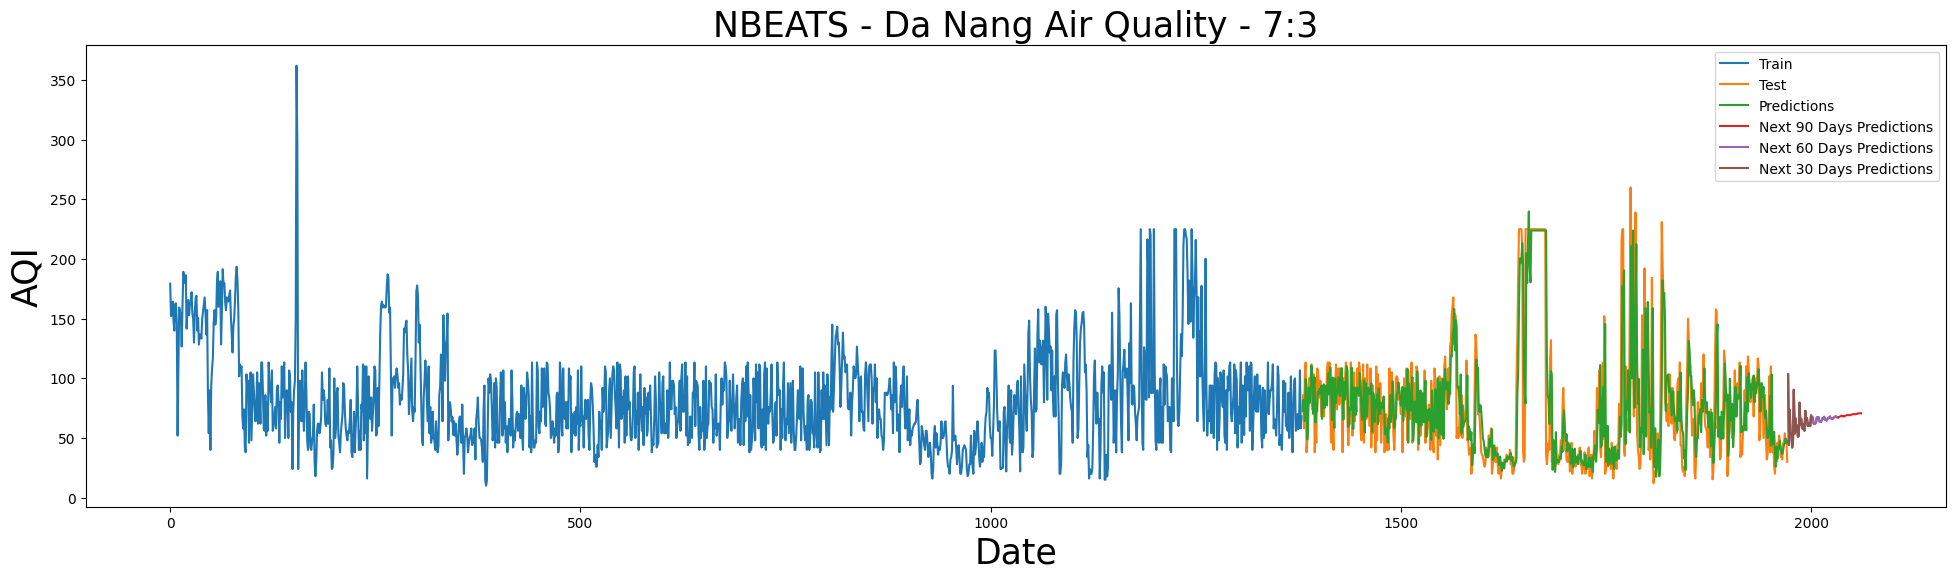

In [54]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Da Nang Air Quality - 7:3', fontsize = 25)
plt.legend()
plt.show()

## Đà Nẵng, Train:Test - 8:2


In [55]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1577, 1577, 395, 395)

In [56]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [57]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_DaNang_82_N-BEATS")

In [58]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [59]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 103: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 203: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [60]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 24ms/step - loss: 25.3559 - mae: 25.3559 - mse: 1539.7557


[25.355884552001953, 25.355884552001953, 1539.7557373046875]

In [61]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 58.221737,  54.678207,  64.0154  ,  64.94983 , 101.13389 ,
        51.734077,  60.841408,  48.49738 ,  48.653435,  51.545116],
      dtype=float32)>

In [62]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 25.355885, 'rmse': 39.23972, 'mape': 48.44521}

In [63]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 39ms/step


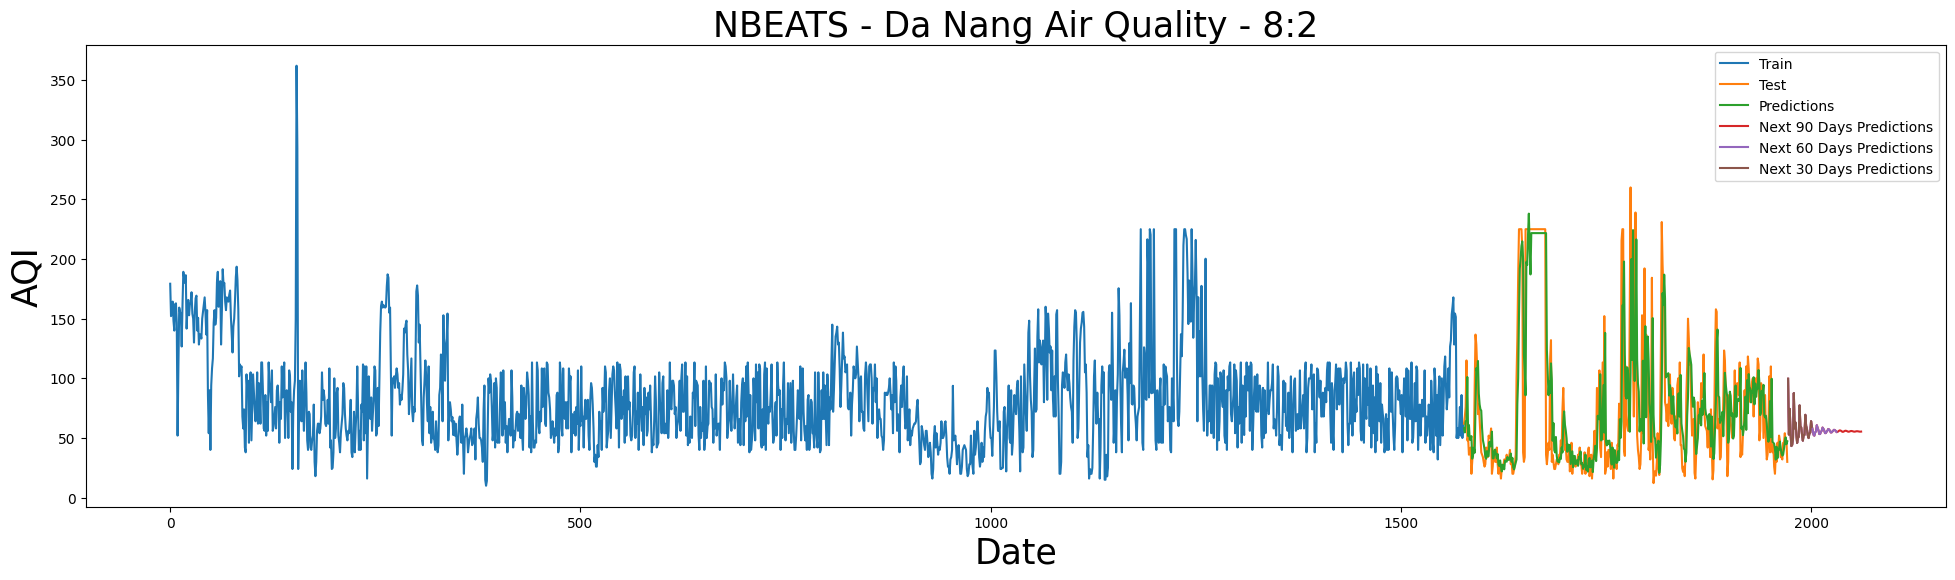

In [64]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Da Nang Air Quality - 8:2', fontsize = 25)
plt.legend()
plt.show()

## Đà Nẵng, Train:Test - 9:1

In [65]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1774, 1774, 198, 198)

In [66]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [67]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_DaNang_91_N-BEATS")

In [68]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [69]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 104: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 204: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [70]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 21ms/step - loss: 28.1068 - mae: 28.1068 - mse: 1606.6239


[28.106843948364258, 28.106843948364258, 1606.6239013671875]

In [71]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 38.576664,  88.34964 ,  75.53451 ,  79.65911 ,  61.709946,
        52.65299 , 115.17476 , 218.65204 ,  98.70803 , 207.07922 ],
      dtype=float32)>

In [72]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 28.106844, 'rmse': 40.082714, 'mape': 45.33908}

In [73]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 22ms/step


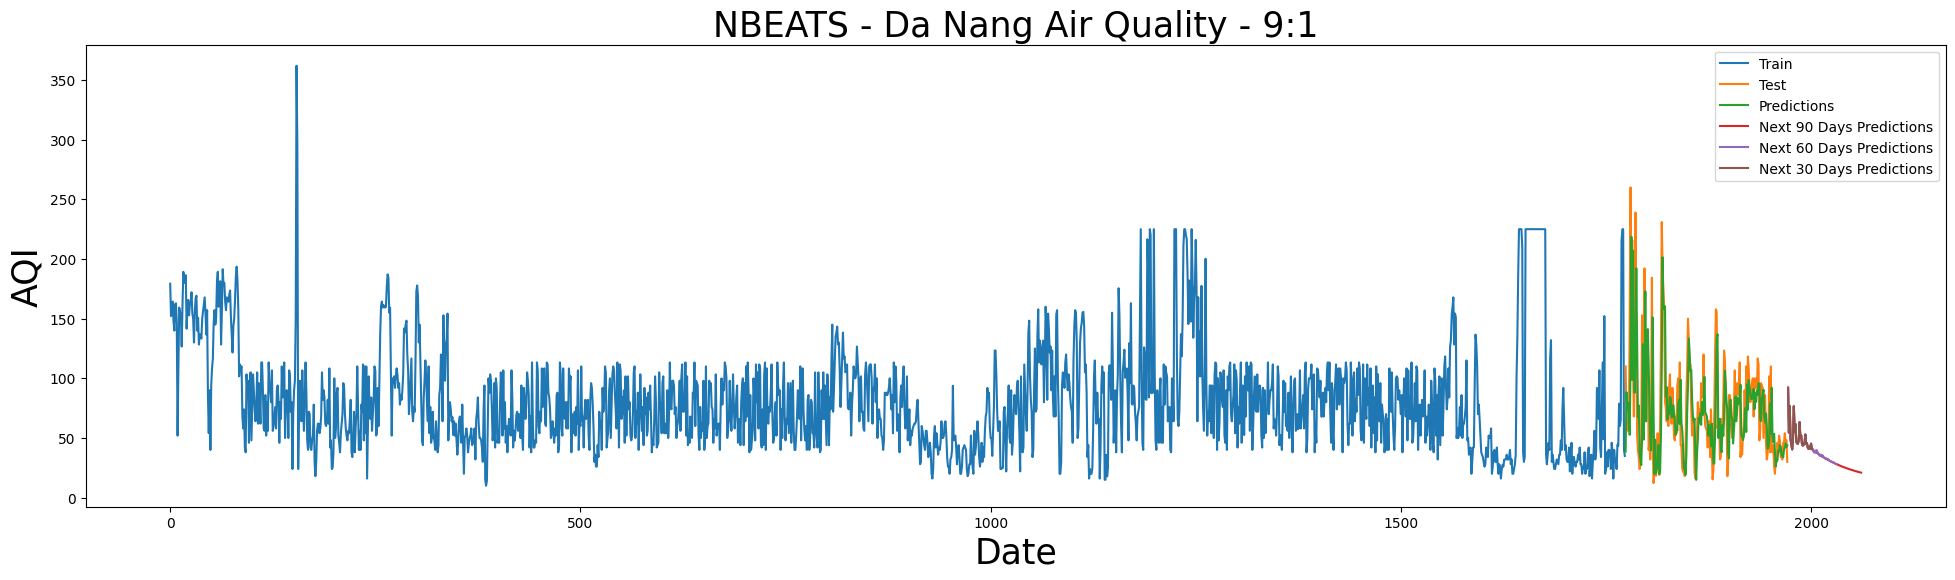

In [74]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Da Nang Air Quality - 9:1', fontsize = 25)
plt.legend()
plt.show()

# Việt Trì

In [75]:
# Thêm các cột window
df_nbeats = df_vt.copy()
for i in range(WINDOW_SIZE):
  df_nbeats[f"AQI+{i+1}"] = df_nbeats["AQI"].shift(periods=i+1)
df_nbeats.dropna().head()

,AQI,AQI+1,AQI+2,AQI+3,AQI+4,AQI+5,AQI+6,AQI+7
date,,,,,,,,
2019-01-08,118.333333,115.000000,84.000000,86.000000,116.666667,60.000000,68.000000,74.000000
2019-01-09,98.000000,118.333333,115.000000,84.000000,86.000000,116.666667,60.000000,68.000000
2019-01-10,111.666667,98.000000,118.333333,115.000000,84.000000,86.000000,116.666667,60.000000
2019-01-11,60.000000,111.666667,98.000000,118.333333,115.000000,84.000000,86.000000,116.666667
2019-01-12,116.666667,60.000000,111.666667,98.000000,118.333333,115.000000,84.000000,86.000000


## Việt Trì, Train:Test - 7:3

In [76]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.7)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1380, 1380, 592, 592)

In [77]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [78]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_VietTri_73_N-BEATS")

In [79]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [80]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 110: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 210: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [81]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 22.7348 - mae: 22.7348 - mse: 838.2296


[22.73482322692871, 22.73482322692871, 838.2296142578125]

In [82]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([76.866066, 54.474365, 76.800316, 78.32192 , 83.87847 , 85.87103 ,
       74.60815 , 84.754326, 72.05994 , 66.46024 ], dtype=float32)>

In [83]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 22.734823, 'rmse': 28.952196, 'mape': 33.43309}

In [84]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 34ms/step


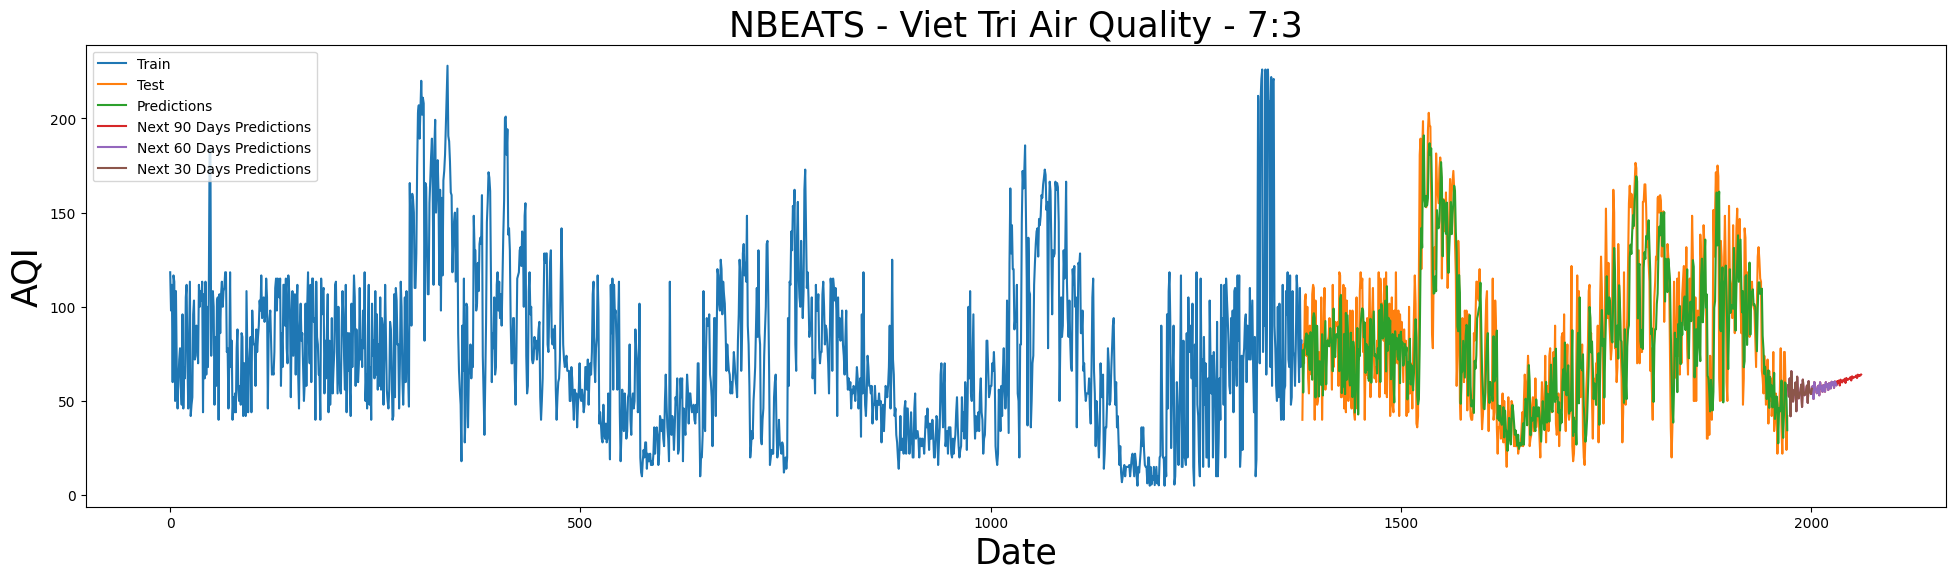

In [85]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Viet Tri Air Quality - 7:3', fontsize = 25)
plt.legend()
plt.show()

## Việt Trì, Train:Test - 8:2

In [86]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1577, 1577, 395, 395)

In [87]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [88]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_VietTri_82_N-BEATS")

In [89]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [90]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 109: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 209: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [91]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 25ms/step - loss: 21.8060 - mae: 21.8060 - mse: 785.6810


[21.805997848510742, 21.805997848510742, 785.6810302734375]

In [92]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([81.555336, 72.16789 , 87.941315, 83.95678 , 86.006096, 60.70102 ,
       81.00494 , 85.279396, 59.3681  , 52.927742], dtype=float32)>

In [93]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 21.805998, 'rmse': 28.030003, 'mape': 35.0856}

In [94]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 26ms/step


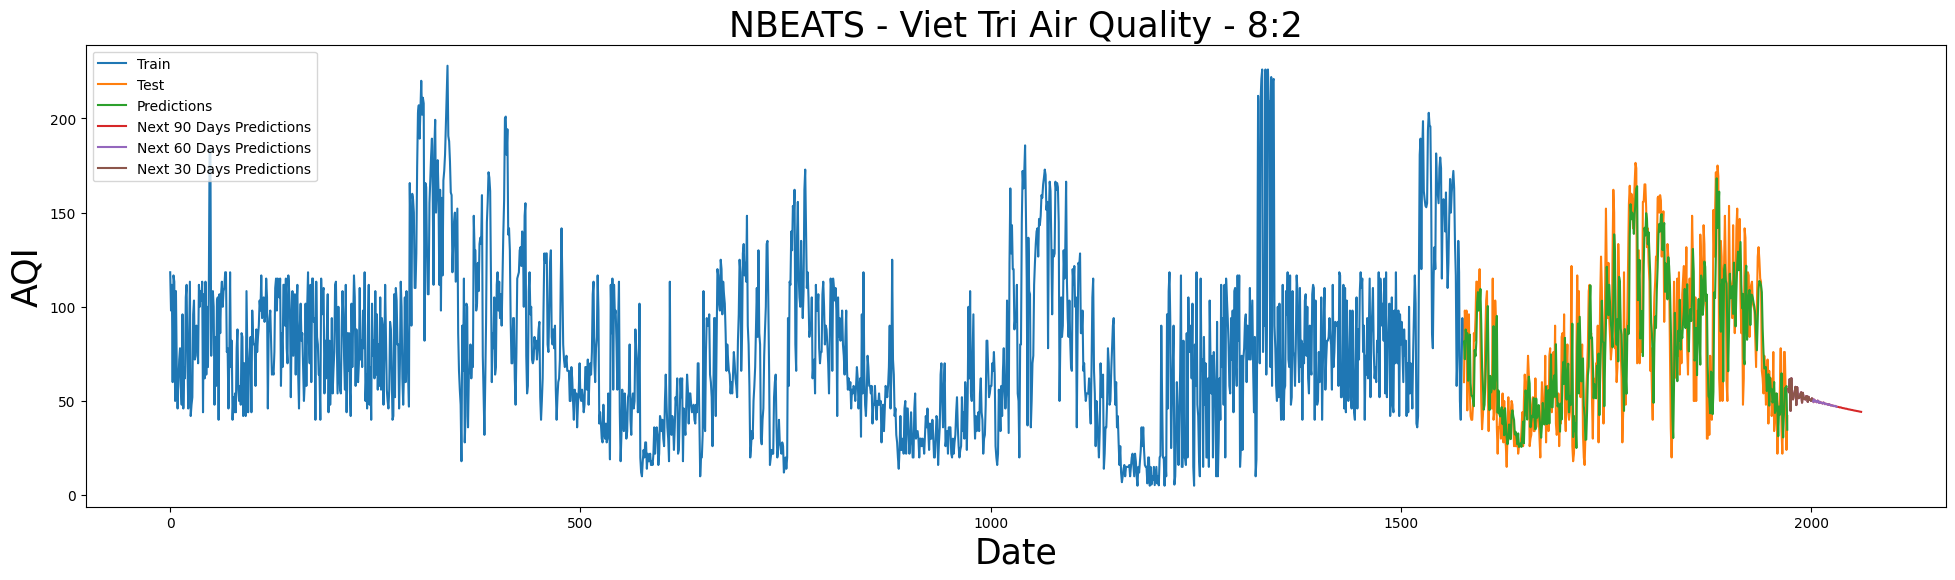

In [95]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Viet Tri Air Quality - 8:2', fontsize = 25)
plt.legend()
plt.show()

## Việt Trì, Train:Test - 9:1

In [96]:
X = df_nbeats.dropna().drop("AQI", axis=1)
y = df_nbeats.dropna()["AQI"]

split_size = int(len(X) * 0.9)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(1774, 1774, 198, 198)

In [97]:
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [98]:
model = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_VietTri_91_N-BEATS")

In [99]:
model.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

In [100]:
model.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản khối lượng lớn kết quả đào tạo
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)])# saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 107: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 207: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [101]:
model.evaluate(test_dataset)

1/1 [==============================] - 0s 27ms/step - loss: 23.3279 - mae: 23.3279 - mse: 913.6923


[23.327871322631836, 23.327871322631836, 913.6922607421875]

In [102]:
model_preds = make_preds(model, test_dataset)
model_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 59.08289,  50.69704,  89.82974,  86.74659,  87.85472, 135.5455 ,
       157.19797, 152.67688, 149.09813, 147.86157], dtype=float32)>

In [103]:
model_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_preds)
model_results

{'mae': 23.327871, 'rmse': 30.227343, 'mape': 31.20076}

In [104]:
import numpy as np
aqi_series = pd.Series(y_test)
y_test = aqi_series.to_frame()
y_test.reset_index(inplace=True)
y_test.columns = ['date', 'AQI']

aqi_series = pd.Series(y_train)
y_train = aqi_series.to_frame()
y_train.reset_index(inplace=True)
y_train.columns = ['date', 'AQI']

model_preds = pd.DataFrame(model_preds, columns=['AQI']).astype(np.float64)

1/1 [==============================] - 0s 24ms/step


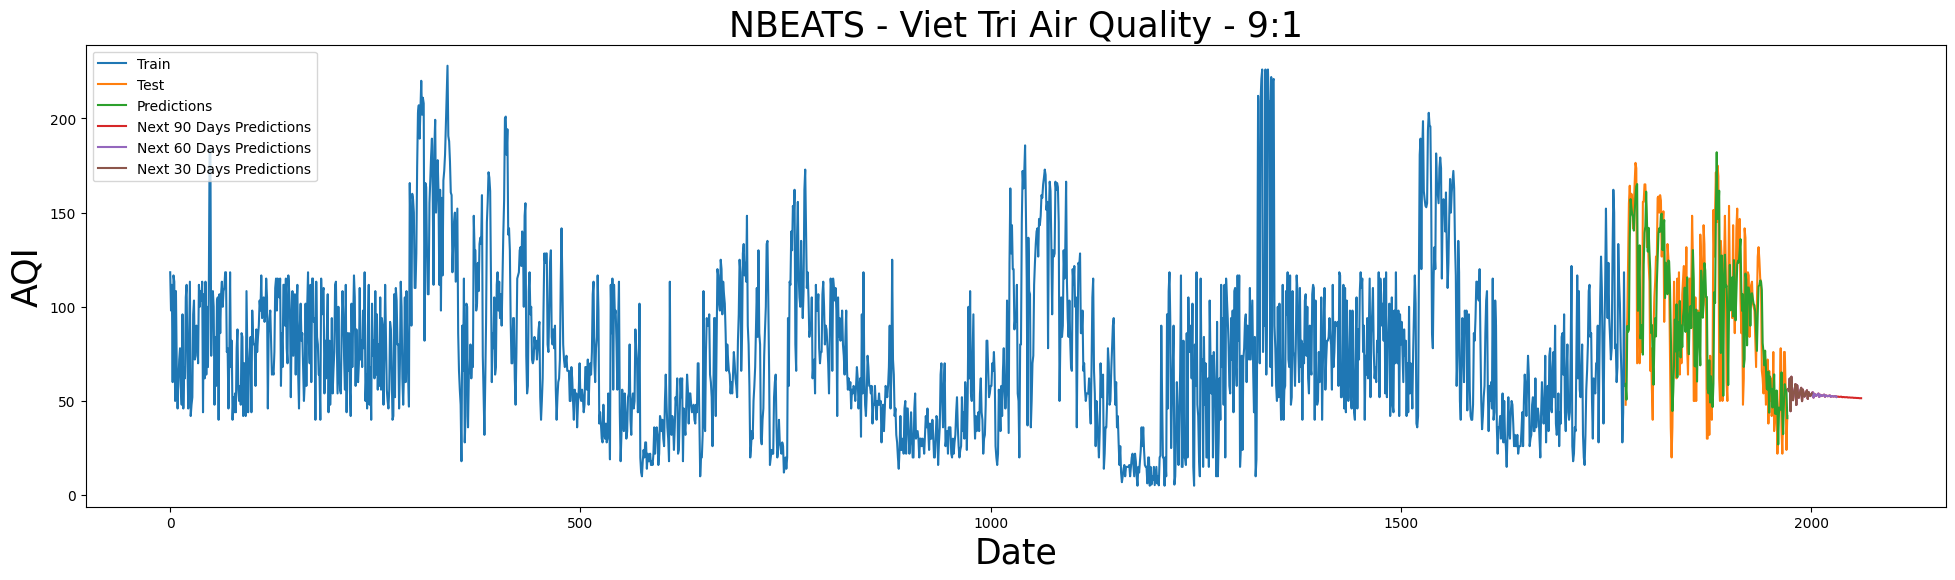

In [105]:
# Nhận các ngày cuối cùng của Window_Size từ bộ kiểm tra làm đầu vào ban đầu
initial_input = X_test.iloc[-20].values

# Dự đoán 30 ngày tiếp theo
next_30_days_predictions = predict_future_aqi(model, initial_input, 30)
next_60_days_predictions = predict_future_aqi(model, initial_input, 60)
next_90_days_predictions = predict_future_aqi(model, initial_input, 90)

# Tạo một khung dữ liệu để lưu trữ các dự đoán
next_30_days_predictions = pd.DataFrame(next_30_days_predictions, columns=['AQI'])
next_60_days_predictions = pd.DataFrame(next_60_days_predictions, columns=['AQI'])
next_90_days_predictions = pd.DataFrame(next_90_days_predictions, columns=['AQI'])

# Vẽ kết quả
plt.figure(figsize=(24, 6))
plt.plot(y_train.index, y_train['AQI'], label='Train')
plt.plot(y_test.index + len(y_train), y_test['AQI'], label='Test')
plt.plot(y_test.index + len(y_train), model_preds['AQI'], label='Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 90), next_90_days_predictions['AQI'], label='Next 90 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 60), next_60_days_predictions['AQI'], label='Next 60 Days Predictions')
plt.plot(np.arange(len(y_train) + len(y_test), len(y_train) + len(y_test) + 30), next_30_days_predictions['AQI'], label='Next 30 Days Predictions')

plt.xlabel('Date', fontsize = 25)
plt.ylabel('AQI', fontsize = 25)
plt.title('NBEATS - Viet Tri Air Quality - 9:1', fontsize = 25)
plt.legend()
plt.show()